In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D , Flatten , Input, Dropout, MaxPool2D, BatchNormalization, Activation, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, Adagrad, SGD
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 6.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=7fdeefcadbba2c51fcb6b4d4e4be978d6d35e6cd6f77e5b32fc87e48a4585aa6
  Stored in directory: /root/.cache/pip/wheels/29/da/11/144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
import os 
os.environ['KAGGLE_CONFIG_DIR '] = '/content'

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d arunrk7/surface-crack-detection

 93% 217M/233M [00:00<00:00, 254MB/s]
100% 233M/233M [00:00<00:00, 263MB/s]


In [ ]:
#Extract Zipped file to the Main Dataset folder
import zipfile
Zipped_File = '/content/surface-crack-detection.zip'
target_dir = '/content/dataset/'
zfile = zipfile.ZipFile(Zipped_File)
zfile.extractall(target_dir)

In [ ]:
Dir_Positive = Path('/content/dataset/Positive')  #Contains Cracks
Dir_Negative = Path('/content/dataset/Negative')  #No Cracks
Pos_filepaths = os.listdir(Dir_Positive)
Neg_filepaths = os.listdir(Dir_Negative)
for i in Dir_Positive , Dir_Negative:
  print(f'samples of {i}',Pos_filepaths[:10])

samples of /content/dataset/Positive ['09916.jpg', '19430.jpg', '02844.jpg', '01237.jpg', '16692_1.jpg', '16714_1.jpg', '13286_1.jpg', '05293.jpg', '00990.jpg', '11377_1.jpg']
samples of /content/dataset/Negative ['09916.jpg', '19430.jpg', '02844.jpg', '01237.jpg', '16692_1.jpg', '16714_1.jpg', '13286_1.jpg', '05293.jpg', '00990.jpg', '11377_1.jpg']


In [ ]:
full_path_pos = [os.path.join(Dir_Positive, img) for img in Pos_filepaths]
full_path_neg = [os.path.join(Dir_Negative, img) for img in Neg_filepaths]
for i in full_path_pos , full_path_neg:
  print('Full path of the image is: ',i[0])

Full path of the image is:  /content/dataset/Positive/09916.jpg
Full path of the image is:  /content/dataset/Negative/09916.jpg


In [ ]:
#list(map(lambda x: os.path.split(x) , list(Dir_Positive.glob(r'*.jpg')))) # to split path from file name
list(Dir_Positive.glob(r'*.jpg')) # to print the full path

**Creating DataFrames**

In [ ]:
def generate_DataFrames(Path , Label):
  FilePath = pd.Series(list(Path.glob(r'*.jpg')), name ='File Path').astype(str)
  label = pd.Series(Label , name = 'Label', index = FilePath.index )
  full_description = pd.concat([FilePath , label] , axis = 1)
  return full_description

In [ ]:
pos_dataFrames = generate_DataFrames(Dir_Positive , 'Positive')
neg_dataFrames = generate_DataFrames(Dir_Negative , 'Negative')
all_dataFrame = pd.concat([pos_dataFrames , neg_dataFrames], axis = 0).sample(frac= 1.0 , random_state=1).reset_index(drop=True) # to shuffle the data we used "sample(frac= 1.0 , random_state=1 )"
all_dataFrame

Show up some Samples of Positive Data

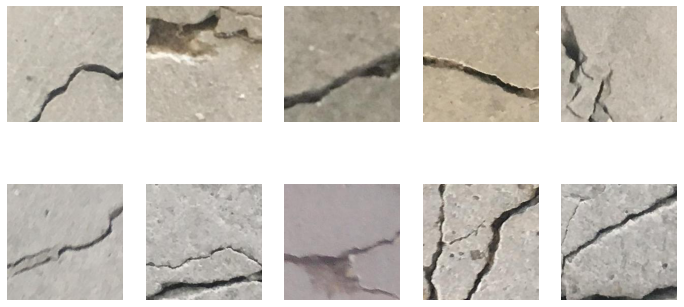

In [ ]:
from PIL import Image
fig, ax = plt.subplots(2,5, figsize=(12, 6), sharex=True, sharey=True)
for image_idx in range(10):
    ax[image_idx//5, image_idx%5].imshow(Image.open(full_path_pos[image_idx]))
    ax[image_idx//5, image_idx%5].axis('off')
plt.show()

**Splitting the Dataset**

In [ ]:
train_set , test_set = train_test_split(all_dataFrame.sample(20000 , random_state=1), 
                                                 test_size=0.2 , shuffle=True , random_state=1)

In [ ]:

print(f'Training data: {train_set.shape} and Testing data: {test_set.shape}')

Training data: (16000, 2) and Testing data: (4000, 2)


#Loading the image Data

We need to rescale the image to avoid the memory issues during the preprocessing the data

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255 , validation_split=0.2)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
train_dataset = train_datagen.flow_from_dataframe(train_set,x_col='File Path', y_col = 'Label',
                                                  target_size=(120, 120), color_mode='rgb', batch_size=32,
                                                  class_mode='binary', seed=42, shuffle=True , subset='training')

val_dataset   = train_datagen.flow_from_dataframe(train_set, x_col = 'File Path', y_col = 'Label',
                                                  target_size=(120, 120), color_mode='rgb', batch_size=32, 
                                                  class_mode='binary', seed=42, shuffle=True , subset='validation')

test_dataset  = test_datagen.flow_from_dataframe(test_set, x_col = 'File Path', y_col = 'Label',
                                                  target_size=(120, 120), color_mode='rgb', batch_size=32, 
                                                  class_mode='binary', seed=42, shuffle=True )

Found 12800 validated image filenames belonging to 2 classes.
Found 3200 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


#Training the MODEL

In [ ]:
'''model = Sequential()
model.add(Input(shape=(227,227,3)))
model.add(Conv2D(filters=30,kernel_size = 4,strides = (1,1), padding = 'same',activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides = (2,2), padding = 'same'))

model.add(Conv2D(filters=16,kernel_size = 3,strides = (1,1), padding = 'same',activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides = (2,2), padding = 'same'))

model.add(Conv2D(filters=10,kernel_size = 3,strides = (1,1), padding = 'same',activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides = (2,2), padding = 'same'))

model.add(Flatten())
model.add(Dense(150,activation = 'relu'))
model.add(Dense(100,activation = 'relu'))

model.add(Dense(1,activation = 'sigmoid'))

model.summary()'''

In [ ]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 32)               0     

In [ ]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
#results=model.fit(train_datagen,  steps_per_epoch=2,epochs=100, validation_data=val_dataset, validation_steps=2)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[ tf.keras.callbacks.EarlyStopping( monitor='val_loss',patience=3, restore_best_weights=True )])

Epoch 1/100
400/400 [==============================] - 31s 59ms/step - loss: 0.5792 - accuracy: 0.7127 - val_loss: 0.4270 - val_accuracy: 0.8344
Epoch 2/100
400/400 [==============================] - 33s 84ms/step - loss: 0.2677 - accuracy: 0.9309 - val_loss: 0.1615 - val_accuracy: 0.9566
Epoch 3/100
400/400 [==============================] - 20s 50ms/step - loss: 0.1519 - accuracy: 0.9594 - val_loss: 0.1191 - val_accuracy: 0.9766
Epoch 4/100
400/400 [==============================] - 20s 50ms/step - loss: 0.1210 - accuracy: 0.9663 - val_loss: 0.0921 - val_accuracy: 0.9678
Epoch 5/100
400/400 [==============================] - 22s 55ms/step - loss: 0.0955 - accuracy: 0.9737 - val_loss: 0.0723 - val_accuracy: 0.9806
Epoch 6/100
400/400 [==============================] - 20s 51ms/step - loss: 0.0862 - accuracy: 0.9756 - val_loss: 0.1116 - val_accuracy: 0.9456
Epoch 7/100
400/400 [==============================] - 20s 51ms/step - loss: 0.0794 - accuracy: 0.9755 - val_loss: 0.0763 - val_ac

In [ ]:
fig = px.line(history.history,
             y=['loss', 'val_loss'],
             labels={'index':'Epoch'},
             title='Training and Validation Loss over Time')

fig.show()

Text(0.5, 0, 'epoch')

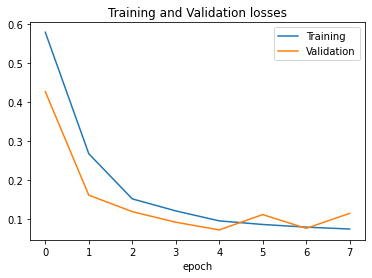

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

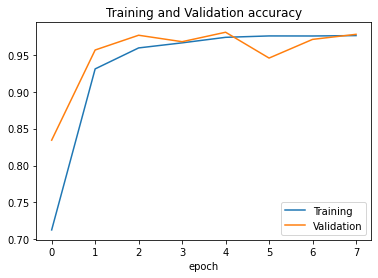

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')

In [ ]:
model.predict(test_dataset)

125/125 [==============================] - 5s 40ms/step


array([[0.9992711 ],
       [0.9999409 ],
       [0.01828459],
       ...,
       [0.9985966 ],
       [0.99993014],
       [0.97911316]], dtype=float32)

In [ ]:
def evaluate_model(model, test_dataset):
    
    results = model.evaluate(test_dataset, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_dataset) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_dataset.labels, y_pred)
    clr = classification_report(test_dataset.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

    Test Loss: 0.08605
Test Accuracy: 97.10%
125/125 [==============================] - 5s 38ms/step


<ipython-input-28-cdcdd4c2b25d>:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



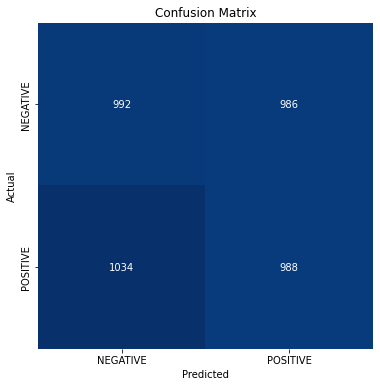

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.49      0.50      0.50      1978
    POSITIVE       0.50      0.49      0.49      2022

    accuracy                           0.49      4000
   macro avg       0.50      0.50      0.49      4000
weighted avg       0.50      0.49      0.49      4000



In [ ]:
evaluate_model(model, test_dataset)

In [ ]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/SavedModels/CNN_model.h5')

In [ ]:
model.save('/content/drive/MyDrive/SavedModels/CNN_model.hdf5')